In [1]:
%matplotlib inline
# from mpl_toolkits.axes_grid1 import make_axes_locatable
import os
import sys
import dpkt
os.environ["CUDA_VISIBLE_DEVICES"] = '0'  # using specific GPU
import tensorflow as tf
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)
tf.logging.set_verbosity(tf.logging.ERROR)

from compatible.likelihoods import MultiClass, Gaussian
from compatible.kernels import RBF, White
from gpflow.models.svgp import SVGP
# from gpflow.training import AdamOptimizer, ScipyOptimizer
from scipy.stats import mode
from scipy.cluster.vq import kmeans2
import gpflow
from gpflow.mean_functions import Identity, Linear
from gpflow.mean_functions import Zero
from gpflow import autoflow, params_as_tensors, ParamList
import pandas as pd
import itertools
pd.options.display.max_rows = 999
import gpflow_monitor

from scipy.cluster.vq import kmeans2
from scipy.stats import norm
from scipy.special import logsumexp
from scipy.io import loadmat
from gpflow_monitor import *
print('tf_ver:', tf.__version__, 'gpflow_ver:', gpflow.__version__)
from tensorflow.python.client import device_lib
print('avail devices:\n'+'\n'.join([x.name for x in device_lib.list_local_devices()]))
from jack_utils.common import time_it
import sys
import gpflow.training.monitor as mon

# our impl
from dgp_graph import *

tf_ver: 1.15.0 gpflow_ver: 1.5.0
avail devices:
/device:CPU:0
/device:XLA_CPU:0
/device:GPU:0
/device:XLA_GPU:0


Using TensorFlow backend.


In [2]:
plt.rcParams['figure.dpi'] = 100
np.random.seed(123456)

# Load data

Input filename

In [3]:
filename='./data/facebook_chat_4b.pcap'

In [4]:
counter=0
last_time=0
data_list=[]

for ts, pkt in dpkt.pcap.Reader(open(filename,'rb')):
    if last_time==0:
        last_time=int(ts)
    else:
        cur_time=int(ts)
        if cur_time==last_time:
            counter+=1
        else:
            data_list.append(counter)
            last_time=cur_time
            counter=1
data_list.append(counter)

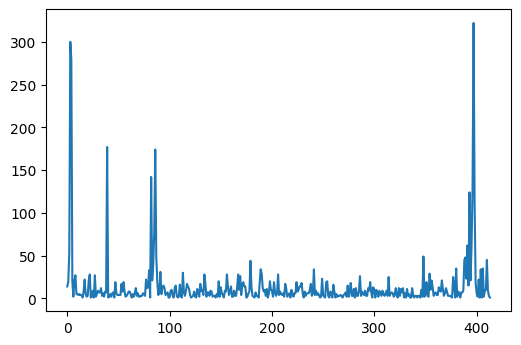

In [5]:
plt.plot(data_list)

# Build data

In [6]:
data_list=np.asarray(data_list)
l=len(data_list)
train_size=int(0.6*l)
test_size=l-train_size

In [7]:
win=5
X_train=np.zeros((train_size-win, win))
Y_train=np.zeros((train_size-win, 1))
X_test=np.zeros((test_size-win, win))
Y_test=np.zeros((test_size-win, 1))

In [8]:
for i in range(train_size-win):
    X_train[i]=data_list[i:i+win]
    Y_train[i,0]=data_list[i+win]

In [9]:
for i in range(test_size-win):
    X_test[i]=data_list[train_size+i:train_size+i+win]
    Y_test[i,0]=data_list[train_size+i+win]

In [10]:
def normalize_data(data, mu, std):
    res = (data-mu) / std
    return res

def unnormalize_data(data, mu, std):
    res = data * std + mu
    return res

In [11]:
trX0 = X_train
trY0 = Y_train

teX0 = X_test
teY0 = Y_test

In [12]:
trX0, teX0 = trX0[:, None, :], teX0[:, None, :]
trY0, teY0 = trY0[:, None, :], teY0[:, None, :]

In [13]:
mu_trX0, std_trX0 = np.mean(trX0, axis=0), np.std(trX0, axis=0)
mu_trY0, std_trY0 = np.mean(trY0, axis=0), np.std(trY0, axis=0)
# mu_teX0, std_teX0 = np.mean(teX0, axis=0), np.std(teX0, axis=0)
# mu_teY0, std_teY0 = np.mean(teY0, axis=0), np.std(teY0, axis=0)

In [14]:
trX = normalize_data(trX0, mu_trX0, std_trX0)
trY = normalize_data(trY0, mu_trY0, std_trY0)
teX = normalize_data(teX0, mu_trX0, std_trX0)
teY = normalize_data(teY0, mu_trY0, std_trY0)

In [15]:
gmat = np.eye(1)

# Data visualization

In [16]:
def imshow2d(x):
    plt.imshow(x.reshape(x.shape[0], -1))
    plt.colorbar()

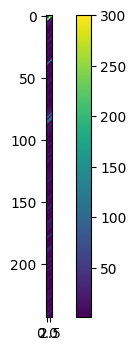

In [17]:
imshow2d(trX0)

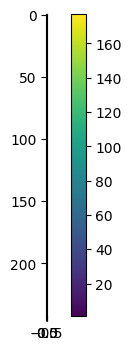

In [18]:
imshow2d(trY0)

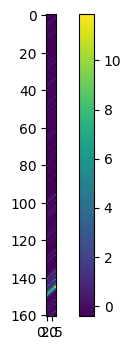

In [19]:
imshow2d(teX)

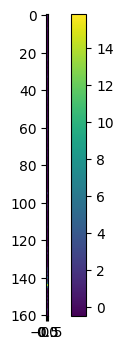

In [20]:
imshow2d(teY)

# Training

In [21]:
nodes = gmat.shape[0]
M = 5

Z = np.stack([kmeans2(trX[:,i], M, minit='points')[0] for i in range(nodes)],axis=1)  # (M=s2=10, n, d_in=5)
print('inducing points Z: {}'.format(Z.shape))

inducing points Z: (5, 1, 5)


In [22]:
adj = gmat.astype('float64')
input_adj = adj # adj  / np.identity(adj.shape[0]) /  np.ones_like(adj)

In [23]:
with gpflow.defer_build():
    m_dgpg = DGPG(trX, trY, Z, [win], Gaussian(), input_adj,
                  agg_op_name='concat3d', ARD=True,
                  is_Z_forward=True, mean_trainable=False, out_mf0=True,
                  num_samples=20, minibatch_size=80,
                  kern_type='RBF'
                  #kern_type='Matern32'
                 )
    # m_sgp = SVGP(X, Y, kernels, Gaussian(), Z=Z, minibatch_size=minibatch_size, whiten=False)
m_dgpg.compile()
model = m_dgpg

input-output dim (5(agg:5)->1)
func __init__ consumed 1.3s


In [24]:
session = m_dgpg.enquire_session()
optimiser = gpflow.train.AdamOptimizer(0.01)
global_step = mon.create_global_step(session)

In [25]:
maxiter=2000

exp_path="./exp/tmp"
#exp_path="./exp/temp"

print_task = mon.PrintTimingsTask()\
    .with_name('print')\
    .with_condition(mon.PeriodicIterationCondition(10))\

checkpoint_task = mon.CheckpointTask(checkpoint_dir=exp_path)\
        .with_name('checkpoint')\
        .with_condition(mon.PeriodicIterationCondition(15))\

with mon.LogdirWriter(exp_path) as writer:
    tensorboard_task = mon.ModelToTensorBoardTask(writer, model)\
        .with_name('tensorboard')\
        .with_condition(mon.PeriodicIterationCondition(100))\
        .with_exit_condition(True)
    monitor_tasks = [tensorboard_task, checkpoint_task] # [print_task, tensorboard_task]
    
       
    with mon.Monitor(monitor_tasks, session, global_step, print_summary=True) as monitor:
        optimiser.minimize(model, step_callback=monitor, global_step=global_step, maxiter=maxiter)

Tasks execution time summary:
tensorboard:	0.2672 (sec)
checkpoint:	16.7433 (sec)


# Results

In [26]:
from jack_utils.my_metrics import *
import matplotlib.pyplot as plt
%matplotlib inline

In [27]:
def assess_model_rmse(model, X_batch, Y_batch, S = 10):
    m, v = model.predict_y(X_batch, S)
    pred = np.mean(m, axis=0)
    var = np.mean(v, axis=0)
    loss = np.sum((Y_batch.flatten()-pred.flatten())**2)
    return loss, pred, var

def batch_assess_rmse(model, X, Y, batch_size=1, S=10):
    n_batches = max(int(len(X)/batch_size), 1)
    rms = len(X) - n_batches*batch_size
    losses, preds, varis = [], [], []
    Xr, Yr = X[-rms:, :], Y[-rms:, :]
    for X_batch, Y_batch in zip(np.split(X[:n_batches*batch_size], n_batches), np.split(Y[:n_batches*batch_size], n_batches)):
        l, pred, vari = assess_model_rmse(model, X_batch, Y_batch, S=S)
        losses.append(l)
        preds.append(pred)
        varis.append(vari)
    if rms > 0:
        l, pred, vari = assess_model_rmse(model, Xr, Yr, S=S)
        losses.append(l)        
        preds.append(pred)
        varis.append(vari)
    ndata = Y.shape[0] * Y.shape[1]
    avg_loss = np.sqrt(np.sum(losses) / ndata)
    y_pred = np.concatenate(preds)
    y_var = np.concatenate(varis)
    return avg_loss, y_pred, y_var

In [28]:
# make predictions of our model
sample_X0, sample_Y0 = teX0, teY0.squeeze()
sample_X, sample_Y = teX, teY.squeeze()

In [29]:
%%time
pred_rmse, predY, varY = batch_assess_rmse(model, sample_X.reshape(sample_X.shape[0], -1), sample_Y.reshape(sample_Y.shape[0], -1))
print(pred_rmse)

1.4626746364996814
CPU times: user 2.01 s, sys: 81.6 ms, total: 2.09 s
Wall time: 1.6 s


In [30]:
predY0 = unnormalize_data(predY[:,:,None], mu_trY0, std_trY0).squeeze()

In [31]:
# show rmse of all baselines
metrics = [np_mae, np_rmse, np_mape]
e_dgp = [np.round(f(predY0, sample_Y0.squeeze()), 3) for f in metrics]
e_last = [np.round(f(sample_X0[:,:,-1], sample_Y0.squeeze()), 3) for f in metrics]
e_ha = [np.round(f(sample_X0.mean(axis=-1), sample_Y0.squeeze()), 3) for f in metrics]
e_mid = [np.round(f(np.median(sample_X0, axis=-1), sample_Y0.squeeze()), 3) for f in metrics]
print('metrics:\t[mae | rmse | mape]')
print('ours DGP:\t', e_dgp)
print('Last baseline:\t', e_last)
print('5s mean baseline:\t', e_ha)
print('5s median baseline:\t', e_mid)

metrics:	[mae | rmse | mape]
ours DGP:	 [11.231, 28.742, 0.858]
Last baseline:	 [17.419, 43.516, 3.537]
5s mean baseline:	 [15.852, 37.469, 1.69]
5s median baseline:	 [14.597, 36.219, 2.281]


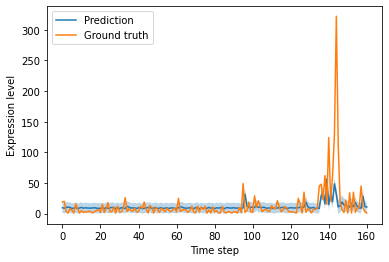

In [32]:
pred=predY0
var=(varY*std_trY0).squeeze()

data=data_list[train_size+win:]

ks=2
yli=0.05

plt.plot(range(test_size-win), pred, label='Prediction')
plt.plot(range(test_size-win), data, label='Ground truth')
plt.fill_between(range(test_size-win), pred-ks*np.sqrt(var), 
                 pred+ks*np.sqrt(var),
                 alpha=0.3)
# plt.ylim([ymin-yli, ymax+yli])
plt.legend()
plt.xlabel('Time step')
plt.ylabel('Expression level')    
plt.show()

# Variance analysis

In [33]:
std_varY0 = np.sqrt(varY)*std_trY0.reshape(1,varY.shape[1])

In [34]:
def correct_rate(predY0, std_varY0, sample_Y0, ndev):
    predY0_ub = predY0 + std_varY0*ndev
    predY0_lb = predY0 - std_varY0*ndev
    tf_mat = np.logical_and(predY0_lb <= sample_Y0, sample_Y0 <= predY0_ub) 
    correct_rate = np.sum(tf_mat) / np.product(tf_mat.shape)
    return correct_rate

In [35]:
correct_rate(predY0, std_varY0, sample_Y0, ndev=1)

0.8968018209174029

In [36]:
correct_rate(predY0, std_varY0, sample_Y0, ndev=2)

0.9518922881061688

In [37]:
correct_rate(predY0, std_varY0, sample_Y0, ndev=3)

0.9751552795031055